## Submitted by 
### Anurag Nagarkoti (239426), Wahab Haseeb Bhatti (239978), Suyash Gawandi (239716)

You do not need to follow the exact same architecture from the paper 
- make it smaller for efficiency reasons
-  one or more “residual blocks” with multiple layers each. 
- You can also leave out batch normalization (this will be treated later in the class) as well as “bottleneck layers” (1x1 convolutions) if you want. 
- build a network with 20-100 layers with as little code duplication as possible?

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model
import keras

In [12]:
(train_images, train_labels),(test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

print("train_images shape: {}".format(train_images.shape))
print("train_labels shape: {}".format(train_labels.shape))
print("test_images shape: {}".format(test_images.shape))
print("test_labels shape: {}".format(test_labels.shape))

train_images shape: (50000, 32, 32, 3)
train_labels shape: (50000, 1)
test_images shape: (10000, 32, 32, 3)
test_labels shape: (10000, 1)


[6]


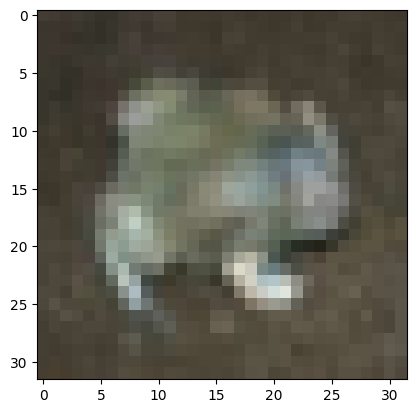

In [13]:
print(train_labels[132])
plt.imshow(train_images[132])

In [14]:
train_labels = train_labels.reshape((-1,)).astype(np.int32)
test_labels  = test_labels.reshape((-1,)).astype(np.int32)
print(test_labels.shape)

(10000,)


In [30]:
#Residual block
@tf.function()
def residual_block(x,filters, strides, downsample_residual):

    x_skip=x

    x = tf.keras.layers.Conv2D(filters,(3,3), strides=strides, activation='relu', padding= 'same')(x)
    #x=tf.keras.layers.BatchNormalization()(x)
    #x= keras.layers.ZeroPadding2D(padding=8)(x)
    x= tf.keras.layers.Conv2D(filters,(3,3), padding= 'same')(x)
    #x=tf.keras.layers.BatchNormalization()(x)

    if downsample_residual==True:
        x_skip= tf.keras.layers.Conv2D(filters,(3,3),strides=strides, activation='relu', padding= 'same')(x_skip)
    
    x= x+ x_skip
    x= tf.keras.layers.Activation('relu')(x)
    

    return x


In [31]:
@tf.function(jit_compile=True)
def model():

    inputs = keras.Input(shape=(32, 32, 3), name="img")

    x= tf.keras.layers.Conv2D(16, kernel_size=(3,3) , padding='same')(inputs) #outputs 32 x 32 x16
    # x= keras.layers.MaxPool2D(pool_size=(3,3), padding='same')(x)
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,32, 2, True) #outputs 16 x 16x 32
    x= residual_block(x,64, 2, True) #outputs 8 x 8 x 64
    x= tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs= tf.keras.layers.Dense(10)(x)

    model= tf.keras.Model(inputs, outputs, name='Resnet')

    return model

In [32]:
import time

In [33]:
st= time.time()

resnet= model()
resnet.compile(optimizer='adam',     
                loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'],
                jit_compile=True
                )

resnet.fit(train_images,train_labels, epochs=10, validation_data=(test_images, test_labels))
et= time.time()
print('elapsed time:', et-st)

TypeError: in user code:

    File "/var/folders/sb/jkv4wnps0yngh86jjg1r5_g40000gn/T/ipykernel_27666/2925638069.py", line 8, in model  *
        x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/keras_tensor.py", line 285, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 16), dtype=tf.float32, name=None), name='conv2d/BiasAdd:0', description="created by layer 'conv2d'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


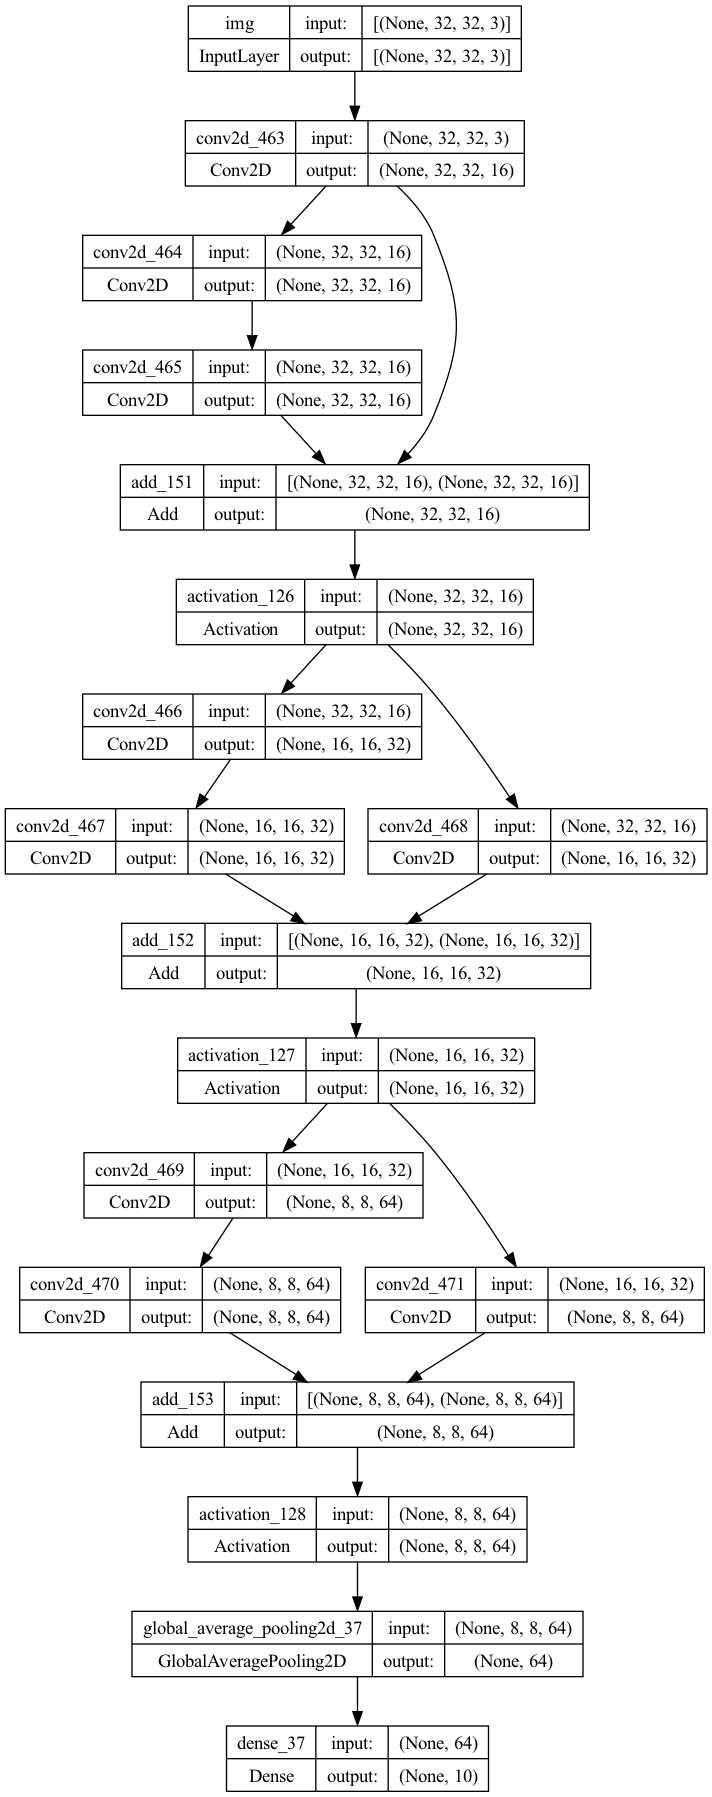

In [ ]:
keras.utils.plot_model(resnet, "mini_resnet.png", show_shapes=True)

#### Conclusions:
- Implemented a smaller version of the  ResNet Architecture for CIFAR10 dataset mentioned in the ResNet paper 
- Ran into errors regarding KerasTensor while trying to implement tf.function graphs: <br>
    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 16), dtype=tf.float32, name=None), name='conv2d/BiasAdd:0', description="created by layer 'conv2d'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.

In [ ]:
st= time.time()
with tf.device('/GPU:0'):
    inputs, outputs= model()


    resnet= keras.Model(inputs, outputs, name='Resnet')
    resnet.compile(optimizer='sgd',     
                    loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'],
                    )

    resnet.fit(train_images,train_labels, epochs=10, validation_data=(test_images, test_labels), batch_size=128)
et= time.time()
print('elapsed time:', et-st)

Epoch 1/10


2023-11-08 01:04:57.069179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - ETA: 0s - loss: nan - accuracy: 0.1002

2023-11-08 01:05:07.628544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - 12s 28ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.1000
Epoch 2/10
391/391 [==============================] - 10s 25ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 3/10
391/391 [==============================] - 10s 27ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 4/10
391/391 [==============================] - 10s 26ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 5/10
391/391 [==============================] - 11s 28ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 6/10
391/391 [==============================] - 10s 26ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 7/10
220/391 [===============>..............] - ETA: 4s - loss: nan - accuracy: 0.0997

KeyboardInterrupt: 

#### Creating Deeper ResNets

In [ ]:
def model():

    inputs = keras.Input(shape=(32, 32, 3), name="img")

    x= tf.keras.layers.Conv2D(16, kernel_size=(3,3) , padding='same')(inputs) #outputs 32 x 32 x16
    # x= keras.layers.MaxPool2D(pool_size=(3,3), padding='same')(x)
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16


    x= residual_block(x,32, 2, True) #outputs 16 x 16x 32
    x= residual_block(x,64, 2, True) #outputs 8 x 8 x 64
    x= tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs= tf.keras.layers.Dense(10)(x)

    return inputs, outputs

In [ ]:
st= time.time()
with tf.device('/GPU:0'):
    inputs, outputs= model()


    resnet= keras.Model(inputs, outputs, name='Resnet')
    resnet.compile(optimizer='adam',     
                    loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'],
                    )

    resnet.fit(train_images,train_labels, epochs=10, validation_data=(test_images, test_labels))
et= time.time()
print('elapsed time:', et-st)

Epoch 1/10


2023-11-08 01:16:04.683770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 2.3184 - accuracy: 0.3615

2023-11-08 01:17:03.252546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 64s 39ms/step - loss: 2.3184 - accuracy: 0.3615 - val_loss: 1.4372 - val_accuracy: 0.4718
Epoch 2/10
1563/1563 [==============================] - 57s 36ms/step - loss: 1.3553 - accuracy: 0.5044 - val_loss: 1.3311 - val_accuracy: 0.5245
Epoch 3/10
1563/1563 [==============================] - 56s 36ms/step - loss: 1.1906 - accuracy: 0.5739 - val_loss: 1.1532 - val_accuracy: 0.6043
Epoch 4/10
1563/1563 [==============================] - 59s 38ms/step - loss: 1.0797 - accuracy: 0.6189 - val_loss: 1.0870 - val_accuracy: 0.6155
Epoch 5/10
1563/1563 [==============================] - 60s 39ms/step - loss: 1.0102 - accuracy: 0.6444 - val_loss: 1.0337 - val_accuracy: 0.6363
Epoch 6/10
1563/1563 [==============================] - 60s 39ms/step - loss: 0.9396 - accuracy: 0.6701 - val_loss: 1.0211 - val_accuracy: 0.6378
Epoch 7/10
1563/1563 [==============================] - 61s 39ms/step - loss: 0.8731 - accuracy: 0.6947 - val_loss: 0.9644 - val_accura

In [ ]:
def model():

    inputs = keras.Input(shape=(32, 32, 3), name="img")

    x= tf.keras.layers.Conv2D(16, kernel_size=(3,3) , padding='same')(inputs) #outputs 32 x 32 x16
    # x= keras.layers.MaxPool2D(pool_size=(3,3), padding='same')(x)
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16

    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16

    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16

    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16

    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16

    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16

    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16

    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16

    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16

    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16
    x= residual_block(x,16, 1, False) #outputs 32 x 32 x 16




    x= residual_block(x,32, 2, True) #outputs 16 x 16x 32
    x= residual_block(x,64, 2, True) #outputs 8 x 8 x 64
    x= tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs= tf.keras.layers.Dense(10)(x)

    return inputs, outputs

In [ ]:
st= time.time()
with tf.device('/GPU:0'):
    inputs, outputs= model()


    resnet= keras.Model(inputs, outputs, name='Resnet')
    resnet.compile(optimizer='adam',     
                    loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'],
                    )

    resnet.fit(train_images,train_labels, epochs=10, validation_data=(test_images, test_labels), batch_size=128)
et= time.time()
print('elapsed time:', et-st)

KeyboardInterrupt: 

#### ResNet with 100+ layers: converged around 45% accuracy in 5 epochs

